In [1]:
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()
[x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

['device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0',
 'device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1c:00.0, compute capability: 7.0',
 'device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1d:00.0, compute capability: 7.0',
 'device: 3, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1e:00.0, compute capability: 7.0']

In [2]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Препроцессинг

In [3]:
from glob import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

## Загрузка изображений

In [4]:
images = []
diseases = []
for culture in glob("dataset/*"):
    for disease in glob(culture+"/*"):
        for s in glob(disease+"/*"):
            img = img_to_array(load_img(s, target_size=(224,224))) 
            diseases.append(culture.split('/')[-1]+"-"+disease.split('/')[-1])
            images.append(img)

images = np.array(images)
diseases = np.array(diseases)
images.shape, diseases.shape

((934, 224, 224, 3), (934,))

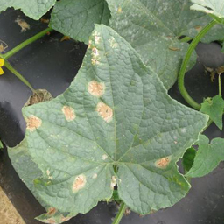

In [5]:
array_to_img(images[0])

## генерация аугментированных изображений

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
X_train, X_test, C_train, C_test = train_test_split(preprocess_input(np.array(images)), diseases, train_size=0.8, test_size=0.2, random_state=777) # поменял на исходные изображения

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

de = LabelEncoder()
num_train_labels = de.fit_transform(C_train)
cat_train_labels = to_categorical(num_train_labels)

num_test_labels = de.fit_transform(C_test)
cat_test_labels = to_categorical(num_test_labels)

In [8]:
images_gen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    horizontal_flip=True)

flow = images_gen.flow(X_train,cat_train_labels)

In [9]:
gen_count = 400
gen_images = []
gen_labels = []
for i in range(gen_count):
    x,y = flow.next()
    gen_images.append(x)
    gen_labels.append(y)
gen_images = np.concatenate(gen_images)
gen_labels = np.concatenate(gen_labels)

/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/anaconda3/envs/myenv2/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [10]:
print(f"Сгенерировано {gen_images.shape[0]} изображений")

Сгенерировано 12464 изображений


## подготовка данных и разбиение выборки 

## Обучение

In [11]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, Input, concatenate 
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

In [12]:
labels_count = np.unique(num_test_labels).size
labels_count

25

In [13]:

restnet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224,224,3)) # загружаем предобученную сеть

output = restnet.layers[-1].output # используем выход пердыдущего слоя
restnet_output = Model(restnet.input, outputs=[output]) # создаем это все дело как модель
for layer in restnet.layers: # замораживаем предобученные слои модели
    layer.trainable = False

#C_input = Input(shape=(C.shape[1]))

conv = Conv2D(600, (5,5))(restnet_output.output)
res_pooling = MaxPooling2D((3,3))(conv)
flat = Flatten()(res_pooling)

#concat_l = concatenate([C_input, flat])

dense_1 = Dense(128, activation='sigmoid')(flat)
drop_1 = Dropout(0.3)(dense_1)
dense_3 = Dense(labels_count, activation='sigmoid')(drop_1)

model = Model(inputs=[restnet_output.input], outputs=[dense_3])
model.compile(loss='categorical_crossentropy', # лейблы кодируются в one-hot
                  optimizer=optimizers.RMSprop(lr=2e-5), # sgd с тюнингом
                  metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [14]:
!nvidia-smi

Mon Mar  8 11:52:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:1A:00.0 Off |                    0 |
| N/A   39C    P0    55W / 300W |  30716MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   35C    P0    57W / 300W |    318MiB / 32510MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [15]:
import datetime

history = model.fit(gen_images, gen_labels,
                    epochs=40,
                    steps_per_epoch=200,
                    validation_steps=30,
                    validation_data=(X_test, cat_test_labels),
                    verbose=1)

Epoch 1/40
200/200 [==============================] - 12s 59ms/step - loss: 2.5434 - accuracy: 0.5254 - val_loss: 2.4037 - val_accuracy: 0.6043
Epoch 2/40
200/200 [==============================] - 10s 49ms/step - loss: 2.2326 - accuracy: 0.7940 - val_loss: 2.2822 - val_accuracy: 0.6738
Epoch 3/40
200/200 [==============================] - 10s 50ms/step - loss: 2.0634 - accuracy: 0.8858 - val_loss: 2.1672 - val_accuracy: 0.6898
Epoch 4/40
200/200 [==============================] - 10s 50ms/step - loss: 1.9070 - accuracy: 0.9339 - val_loss: 2.0566 - val_accuracy: 0.7005
Epoch 5/40
200/200 [==============================] - 10s 50ms/step - loss: 1.7440 - accuracy: 0.9634 - val_loss: 1.9543 - val_accuracy: 0.7059
Epoch 6/40
200/200 [==============================] - 10s 50ms/step - loss: 1.5871 - accuracy: 0.9747 - val_loss: 1.8532 - val_accuracy: 0.6845
Epoch 7/40
200/200 [==============================] - 10s 50ms/step - loss: 1.4274 - accuracy: 0.9868 - val_loss: 1.7444 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss","val_loss"])

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot((np.array(history.history["val_accuracy"])+np.array(history.history["accuracy"]))/2)
plt.legend(["accuracy","val_accuracy"])

# Анализ результатов

In [16]:
def predict(n):
    img = preprocess_input(np.array([images[n]]))
    predicted = np.argmax(model.predict(img))
    plt.imshow(images[n].astype("int"))
    actual = np.argmax(D[n])
    return de.inverse_transform([predicted, actual])

In [17]:
def find_failed():
    transformed = preprocess_input(np.array(images))
    predicted = model.predict(transformed)
    for i in range(predicted.shape[0]):
        p = de.inverse_transform([np.argmax(predicted[i])])[0]
        a = diseases[i]
        if(p!=a):
            print((i,a,p))

In [18]:
print("id, predicted, actual")
find_failed()

id, predicted, actual
(1, 'Cucumbers-Anthracnose', 'Grape-Healthy')
(38, 'Cucumbers-Healthy', 'Cucumbers-Nutrient deficiency')
(43, 'Cucumbers-Healthy', 'Grape-Healthy')
(48, 'Cucumbers-Healthy', 'Grape-Healthy')
(73, 'Cucumbers-Downy mildew', 'Cucumbers-Healthy')
(75, 'Cucumbers-Downy mildew', 'Cucumbers-Anthracnose')
(93, 'Cucumbers-Downy mildew', 'Cucumbers-Nutrient deficiency')
(97, 'Cucumbers-Downy mildew', 'Cucumbers-Anthracnose')
(104, 'Cucumbers-Nutrient deficiency', 'Cucumbers-Powdery mildew')
(128, 'Cucumbers-Nutrient deficiency', 'Cucumbers-Healthy')
(141, 'Cucumbers-Powdery mildew', 'Cotton-Powdery mildew')
(145, 'Cucumbers-Powdery mildew', 'Cucumbers-Healthy')
(170, 'Wheat-Black chaff', 'Wheat-Healthy')
(232, 'Wheat-Yellow rust', 'Wheat-Brown rust')
(256, 'Wheat-Yellow rust', 'Wheat-Brown rust')
(262, 'Wheat-Brown rust', 'Wheat-Yellow rust')
(269, 'Wheat-Brown rust', 'Wheat-Yellow rust')
(270, 'Wheat-Brown rust', 'Wheat-Yellow rust')
(282, 'Wheat-Brown rust', 'Wheat-Black 

In [19]:
def get_by_name(name):
    return list(filter(lambda x: x[1] == name, enumerate(diseases)))

In [20]:
get_by_name('Cotton-Healthy')[0][0]

780

In [21]:
def draw(id):
    plt.figure()
    plt.title(diseases[id])
    plt.imshow(images[id].astype("int")[:,:])

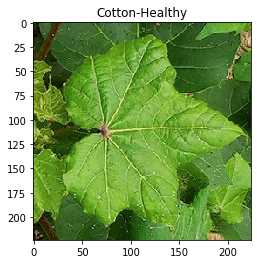

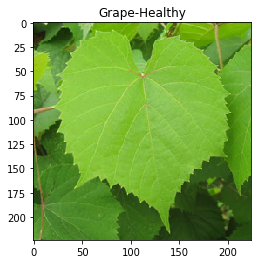

In [29]:
draw(get_by_name('Cotton-Healthy')[1][0])
draw(get_by_name('Grape-Healthy')[1][0])